# Predict low, high strategy  EDA

To install conda and binance packages to this notebook uncomment the code below

In [1]:
%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
%pip install plotly==5.9.0
%pip install twisted
%pip install binance-connector==1.13.0
%pip install pandas
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [2]:
#mode="dev"
symbol="BTCUSDT"
mode="yc"
exchange="huobi"
strategy="SimpleKerasStrategy"
#strategy="LSTMStrategy2"

In [3]:

import os

# Downloading latest pytrade2 data
if mode == "yc":
    os.system("cd ./../deploy/yandex_cloud; ./download_data.sh")
    data_dir=f"../data/yandex-cloud"
else:
    data_dir=f"../data/dev"
    
print(f"Download completed. Local data dir: {data_dir}")

    

receiving incremental file list
LSTMStrategy/LSTMStrategy.db
LSTMStrategy/Xy/2023-06-16_BTCUSDT_X.csv
LSTMStrategy/Xy/2023-06-16_BTCUSDT_data.csv
LSTMStrategy/Xy/2023-06-16_BTCUSDT_y.csv
LSTMStrategy/account/2023-06-16_balance.csv
LSTMStrategy/weights/2023-06-16T05:23:05.463481.data-00000-of-00001
LSTMStrategy/weights/2023-06-16T05:23:05.463481.index
LSTMStrategy/weights/checkpoint
LSTMStrategy2/LSTMStrategy2.db
LSTMStrategy2/Xy/2023-06-16_BTCUSDT_X.csv
LSTMStrategy2/Xy/2023-06-16_BTCUSDT_data.csv
LSTMStrategy2/Xy/2023-06-16_BTCUSDT_y.csv
LSTMStrategy2/account/2023-06-16_balance.csv
LSTMStrategy2/weights/2023-06-16T05:22:51.627093.data-00000-of-00001
LSTMStrategy2/weights/2023-06-16T05:22:51.627093.index
LSTMStrategy2/weights/checkpoint
SimpleKerasStrategy/SimpleKerasStrategy.db
SimpleKerasStrategy/Xy/2023-06-16_BTCUSDT_X.csv
SimpleKerasStrategy/Xy/2023-06-16_BTCUSDT_data.csv
SimpleKerasStrategy/Xy/2023-06-16_BTCUSDT_y.csv
SimpleKerasStrategy/account/2023-06-16_balance.csv
SimpleKerasS

## Init Huobi or Binance client

In [4]:
import os
import sys
import yaml
from binance.spot import Spot as Client
from huobi.client.account import AccountClient
from huobi.client.algo import AlgoClient
from huobi.client.market import MarketClient
from huobi.client.trade import TradeClient


def load_config_files(cfg_dir:str, paths:{})->{}:
    config={}
    for path in paths:
        fullpath=f"{cfg_dir}/{path}"
        with open(fullpath) as file:
            print("Reading config from "+fullpath)
            config.update(yaml.safe_load(file))
    return config

def load_config_local(strategy:str):
    """
    Load config from cfg folder respecting the order: defaults, app.yaml, environment vars
    """
    print("Reading local config")
    # Defaults
    cfg_dir="./../pytrade2/cfg"
    paths=["app-defaults.yaml", "app.yaml"]
    return load_config_files(cfg_dir, paths)

def load_config_yc(strategy):
    """
    Load config from cfg folder respecting the order: defaults, app.yaml, environment vars
    """
    strategy=strategy.lower()
    print("Reading yc config")
    project_dir="./.."
    cfg_dir=f"{project_dir}/deploy/yandex_cloud/secret/"
    paths=["app.yaml", f"{strategy}.yaml"]

    # Load yc config
    config = load_config_local(strategy)
    config.update(load_config_files(cfg_dir, paths))
    return config

def load_config(strategy):
    """ Read yc or dev config"""
    strategy = strategy.lower()
    return load_config_yc(strategy) if mode == "yc" else load_config_local(strategy)


def create_binance_client(strategy: str, mode: str):
        """ Binance client creation """
        print(mode)
        # Read configs to get keys from there
        strategy=strategy.lower()
        config = load_config(strategy)
        key,secret=config[f"pytrade2.exchange.{exchange}.connector.key"],config[f"pytrade2.exchange.{exchange}.connector.secret"],config[f"pytrade2.exchange.{exchange}.spot.url"]
        return Client(key=key, secret=secret, base_url=url, timeout=10)
#         key,secret,url=config[f"pytrade2.exchange.{exchange}.connector.key"],config[f"pytrade2.exchange.{exchange}.connector.secret"],config[f"pytrade2.exchange.{exchange}.spot.url"]
#         return Client(key=key, secret=secret, base_url=url, timeout=10)

def create_huobi_clients(config, strategy: str, mode: str):
    """ Huobi client creation """
    strategy=strategy.lower()
    key,secret=config[f"pytrade2.exchange.huobi.connector.key"],config[f"pytrade2.exchange.huobi.connector.secret"]
    return  MarketClient(api_key=key, secret_key=secret), \
            AccountClient(api_key=key, secret_key=secret), \
            TradeClient(api_key=key, secret_key=secret)


if exchange == "binance":
    binance_client = create_binance_client(strategy, mode)
    print("Created Binance client")
elif exchange == "huobi":
    config=load_config(strategy.lower())
    huobi_market_client, huobi_account_client, huobi_trade_client = create_huobi_clients(config, strategy, mode)
    huobi_account_id = config["pytrade2.broker.huobi.account.id"]
    symbol=symbol.lower()

Reading yc config
Reading local config
Reading config from ./../pytrade2/cfg/app-defaults.yaml
Reading config from ./../pytrade2/cfg/app.yaml
Reading config from ./../deploy/yandex_cloud/secret//app.yaml
Reading config from ./../deploy/yandex_cloud/secret//simplekerasstrategy.yaml


## Account and orders

### Account info

In [5]:
def print_binance_account():
    account=client.account()
    usdt_free=[a["free"] for a in account["balances"] if a["asset"]=="USDT"]
    # update_time=account["update_time"]
    # print(f"account update time:{update_time}")
    print(f"My USDT amount({strategy}): {usdt_free}")

    print(account)
    print(str(pd.to_datetime(account["updateTime"], unit="ms")))
# btc 1.15798200
#usdt 5134.30859706 26.04.2023 14:26
# usdt amount 
# 14.05.2023 9602.27USDT
# 14.05.2023 9613.27USDT
# 15.05.2023 12:11 10851.4496USDT
# 15.05.2023 15:26 USDT 10824.09131356, BTC 0.97100000
# 16.05.2023 19:12 USDT 10824.13392356 BTC 0.97100000
# 16.05.2023 22:09 USDT 10824.13237356, BTC 0.971
# 17.05.2023 0:47  USDT 10824.08461448 BTC 0.971
# 17.05.2023 9:44 USDT 10824.05857448 BTC 0.971
# 17.05.2023 17:22 USDT 10824.00134797 BTC 0.971
# 18.05.2023 08:25:81 USDT 10823.33222738 BTC 0.971
# 18.05.2023 23:09 USDT 10821.81933906 BTC 0.971
# 18.05.2023 07:22 USDT 10821.70723260 BTC 0.971 
# 19.05.2023 15:20 USDT 10820.82563494 locked 27.12356000 BTC 9.970
# 19.95.2023 15:25 USDT 10821.09770494 BTC 0.971

# Set sharp ratio=4
# 19.05.2023 19:36 USDT 10794.27474497 BTC 0.971
# 20.05.2023 15:35 USDT 10821.28357494 BTC 0.971
def print_huobi_account():
    print("Balance:")
    balances = huobi_account_client.get_balance(account_id=huobi_account_id)
    for b in filter(lambda b: b.balance != "0", balances):
        print(vars(b))
    
if exchange == "binance":
    print_binance_account()
elif exchange == "huobi":
    print_huobi_account()


Balance:
{'currency': 'usdt', 'type': 'trade', 'balance': '25.758387783104689347'}
{'currency': 'usdt', 'type': 'frozen', 'balance': '0.000000000000000052'}
{'currency': 'ht', 'type': 'trade', 'balance': '2.936833385856810282'}
{'currency': 'btc', 'type': 'trade', 'balance': '0.001605686714081168'}


### Orders from Exchange

In [6]:
def huobi_order_vars(order):
    """ Convert huobi order to it's attributes """
    order.created_at = pd.to_datetime(order.created_at, unit='ms')
    if order.finished_at: order.finished_at = pd.to_datetime(order.finished_at, unit='ms')
    if order.canceled_at: order.canceled_at = pd.to_datetime(order.canceled_at, unit='ms')
    return vars(order)

In [7]:
def get_binance_orders():
    orders = pd.DataFrame(client.get_orders(symbol))
    for timecol in ["time", "updateTime", "workingTime"]:
        orders[timecol] = pd.to_datetime(orders[timecol], unit='ms')
    return orders.set_index("time", drop=False)

def get_huobi_orders():
    orders = huobi_trade_client.get_orders(symbol=symbol, order_state="filled")
    orders = pd.DataFrame([huobi_order_vars(o) for o in orders]).set_index("finished_at", drop=False)
    return orders

if exchange == "binance":
    get_binance_orders().tail()
elif exchange == "huobi":
    orders = get_huobi_orders()

if exchange == "binance":
    orders = get_binance_orders()
elif exchange == "huobi"    :
    orders = get_huobi_orders()

orders.tail()


id   symbol  account_id                amount                     price              created_at  canceled_at             finished_at            type         filled_amount     filled_cash_amount           filled_fees source   state client_order_id stop_price  next_time operator
finished_at                                                                                                                                                                                                                                                                                                                
2023-06-14 20:11:46.478  828907397318172  btcusdt    57017616  0.000500000000000000  25559.000000000000000000 2023-06-14 20:11:46.445            0 2023-06-14 20:11:46.478  sell-limit-fok  0.000500000000000000  12.780995000000000000  0.020449592000000000    api  filled                                     0         
2023-06-14 18:44:44.620  828906642319588  btcusdt    57017616  0.000500000000000000  25718.210000000000000000 2023-06-14 18:44:44.599            0 2023-06-14 18:44:44.620      sell-limit  0.000500000000000000  12.989995000000000000  0.020783992000000000    api  filled                                     0         
2023-06-14 18:14:04.949  828906407299496  btcusdt    57017616  0.000500000000000000  25876.870000000000000000 2023-06-14 18:14:04.930            0 2023-06-14 18:14:04.949   buy-limit-fok  0.000500000000000000  12.938435000000000000  0.000000800000000000    api  filled                                     0         
2023-06-14 18:08:02.713  828906306510190  btcusdt    57017616  0.000500000000000000  26024.240000000000000000 2023-06-14 18:08:02.699            0 2023-06-14 18:08:02.713       buy-limit  0.000500000000000000  12.883050000000000000  0.000000800000000000    api  filled                                     0         
2023-06-14 18:05:37.284  828906264233207  btcusdt    57017616  0.000500000000000000  25900.000000000000000000 2023-06-14 18:05:37.236            0 2023-06-14 18:05:37.284  sell-limit-fok  0.000500000000000000  12.953560000000000000  0.020725696000000000    api  filled                                     0

### Opened orders from Exchange

In [8]:
def get_binance_opened_orders():
    orders=pd.DataFrame(client.get_open_orders(symbol))

    for timecol in ["time", "updateTime", "workingTime"]:
        if timecol in orders.columns:
            orders[timecol] = pd.to_datetime(orders[timecol], unit='ms')
    if "time" in orders.columns:
        orders.set_index("time", drop=False, inplace=True)
    return order


    
def get_huobi_opened_orders():
    opened_orders = huobi_trade_client.get_open_orders(symbol=symbol, account_id = huobi_account_id)
    opened_orders = pd.DataFrame([huobi_order_vars(o) for o in opened_orders])
    if not opened_orders.empty: opened_orders = opened.orders.set_index("created_at").round(2)
    return opened_orders



if exchange == "binance":
    opened_orders = get_binance_opened_orders()
elif exchange == "huobi"    :
    opened_orders = get_huobi_opened_orders()

print("Opened orders")    
opened_orders.tail()


Opened orders


Empty DataFrame
Columns: []
Index: []

### My trades from binance

In [9]:
def print_binance_trades():
    mytrades=pd.DataFrame(client.my_trades(symbol))
    mytrades["time"] = pd.to_datetime(mytrades["time"], unit='ms')
    mytrades.tail()

if exchange == "binance":
    print_binance_trades()

### Trades from bot database

In [10]:
import pandas as pd
import numpy as np

def get_trades(data_dir: str, strategy: str, mode: str):
    import sqlite3
    db_path=f"{data_dir}/{strategy}/{strategy}.db"
    fee=0.0012
    print(f"Get trades from {db_path}")

    with sqlite3.connect(db_path) as conn:
        trades=pd.read_sql_query("SELECT * FROM trade ORDER BY open_time",conn,
                                 parse_dates=["open_time", "close_time"])#.set_index("open_time", drop=False)
    trades["profit"] = np.where(trades["side"] == "BUY", 
                                (trades["close_price"]-trades["open_price"])*trades["quantity"],
                                (trades["open_price"]-trades["close_price"])*trades["quantity"],
                               )
    trades["profit"] = trades["profit"] - fee*(trades["open_price"] + trades["close_price"])*trades["quantity"]
    trades["cum_profit"] = trades["profit"].cumsum()
    
    return trades

trades=get_trades(data_dir, strategy, mode)
trades.tail()

Get trades from ../data/yandex-cloud/SimpleKerasStrategy/SimpleKerasStrategy.db


id   ticker  side               open_time  open_price    open_order_id  stop_loss_price  take_profit_price stop_loss_order_id trailing_delta  quantity              close_time  close_price   close_order_id  status    profit  cum_profit
100  101  btcusdt  SELL 2023-06-13 12:34:15.914    26277.51  808238972507693         26347.75           26182.20    808238904711226           None    0.0005 2023-06-13 13:34:56.606     26128.00  808239450264666  closed  0.043312   -4.143553
101  102  btcusdt  SELL 2023-06-14 18:05:37.240    25907.12  828906264233207         25975.12           25772.55    828906281567683           None    0.0005 2023-06-14 18:08:02.713     26024.24  828906306510190  closed -0.089719   -4.233272
102  103  btcusdt   BUY 2023-06-14 18:14:04.934    25876.87  828906407299496         25812.01           25979.94    828906407168670           None    0.0005 2023-06-14 18:44:44.620     25718.21  828906642319588  closed -0.110287   -4.343559
103  104  btcusdt  SELL 2023-06-14 20:11:46.448    25561.99  828907397318172         25659.99           25371.84    828907397383118           None    0.0005 2023-06-15 03:57:33.969     25072.01  828911121302549  closed  0.214610   -4.128949
104  105  btcusdt  SELL 2023-06-15 09:16:29.282    25009.37  828913839702525         25133.36           24678.15    828913839904905           None    0.0005 2023-06-15 17:58:24.993     25135.00             None  closed -0.092902   -4.221851

In [11]:
print(f"Total profit: {trades['profit'].sum()}")


Total profit: -4.2218508459999855


### Opened trades from trade bot database

In [12]:
trades[trades.close_time.isna()].tail()

Empty DataFrame
Columns: [id, ticker, side, open_time, open_price, open_order_id, stop_loss_price, take_profit_price, stop_loss_order_id, trailing_delta, quantity, close_time, close_price, close_order_id, status, profit, cum_profit]
Index: []

## Profit

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_theme()
#paper, notebook, talk, poster

import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
pio.renderers.default = "plotly_mimetype+notebook"
import plotly.graph_objects as go

    
plot_figsize=(10,5)


def plot_profits_plotly(trades):
    """ Plot profit charts using plotly"""
    px.line(trades, x="open_time", y="profit", title=f"{strategy} profit").update_traces(mode='lines+markers').show()
    px.line(trades, x="open_time", y="cum_profit", title=f"{strategy} cumulative profit").update_traces(mode='lines+markers').show()

def plot_profits_sns(trades):
    """ Plot profit charts using sns"""
    plt.figure(figsize=plot_figsize)
    sns.set_style("darkgrid")
    sns.lineplot(data=trades, x="open_time", y="profit").set_title(f"{strategy} profit")
    plt.show()

    #sns.set_palette("deep")
    sns.set_style("whitegrid")
    plt.figure(figsize=plot_figsize)
    sns.lineplot(data=trades, x="open_time", y="cum_profit").set_title( f"{strategy} cumulative profit")
    plt.show()
    
    # Cumulative profit w/o outliers
    profit=trades[["open_time","profit"]].set_index("open_time")
    q_low = profit["profit"].quantile(0.1)
    q_hi  = profit["profit"].quantile(0.9)
    profit_filtered = profit[(profit["profit"] < q_hi) & (profit["profit"] > q_low)]
    cumsum_filtered = profit_filtered.cumsum()
    plt.figure(figsize=plot_figsize)
    sns.set_style("darkgrid")
    sns.lineplot(data=cumsum_filtered).set_title(f"{strategy} profit w/o outliers")
    plt.show()

def plot_profits_plt(trades):
    """ Plot profits using matplotlib """
    plt.figure(figsize=(10,5))
    sns.set_style("whitegrid")
    plt.plot("open_time", "profit", data=trades)
    plt.title(f"{strategy} profit")
    plt.show()
    
    sns.set_style("darkgrid")
    plt.figure(figsize=(10,5))
    plt.plot("open_time", "cum_profit", data=trades)
    plt.title(f"{strategy} cumulative profit")
    plt.show()

plot_profits_plotly(trades)
#plot_profits_sns(trades[:-1:])
#plot_profits_plt(trades)


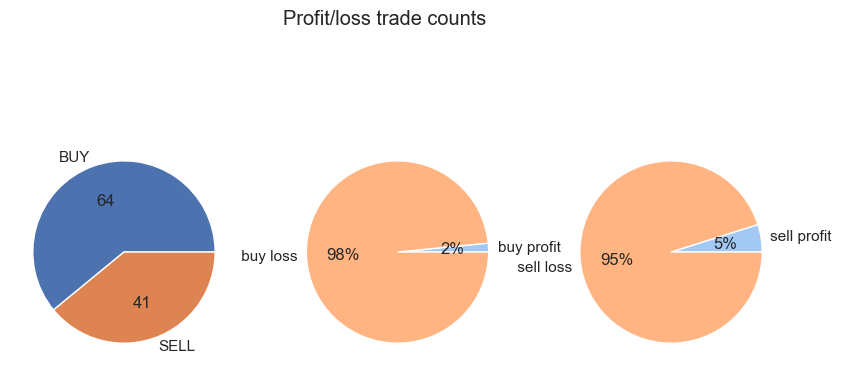

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns


def plot_trade_counts(trades):
    buy_sell_counts = trades["side"].value_counts()
    total=len(trades)
    colors = sns.color_palette('pastel')[0:5]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(plot_figsize)
    fig.suptitle('Profit/loss trade counts')
    # Buy/sell counts
    ax1.pie([len(trades[trades["side"]=="BUY"]),len(trades[trades["side"]=="SELL"])], 
            labels=["BUY","SELL"], \
            autopct=lambda p: '{:.0f}'.format(p * total / 100))
    # Buy profit/loss counts
    ax2.pie([len(trades[(trades["side"]=="BUY") &  (trades["profit"]>0)].index),\
            len(trades[(trades["side"]=="BUY") &  (trades["profit"]<0)].index) \
            ],
            labels=["buy profit", " buy loss"], autopct="%.0f%%", colors=colors)
    # Sell profit/loss counts
    ax3.pie([len(trades[(trades["side"]=="SELL") &  (trades["profit"]>0)].index),\
            len(trades[(trades["side"]=="SELL") &  (trades["profit"]<0)].index) \
            ],
            labels=["sell profit", " sell loss"], autopct="%.0f%%", colors=colors)

    
plot_trade_counts(trades)



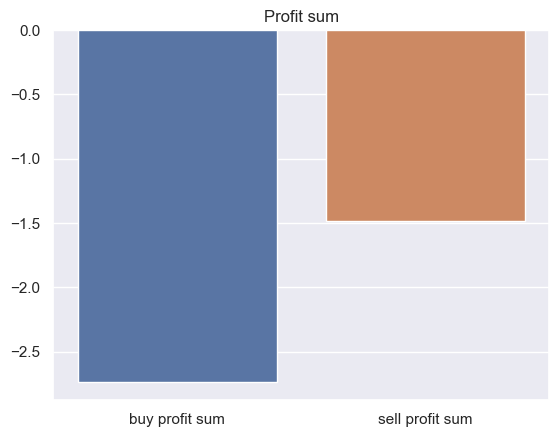

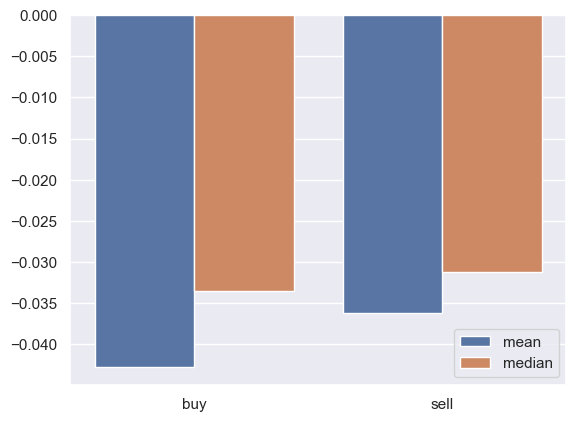

In [15]:
import plotly.express as px

def plot_profit_stat_plotly(trades):
    """ Profit statistics: summary, average """
    buy_profit = trades.loc[trades["side"]=="BUY","profit"]
    sell_profit = trades.loc[trades["side"]=="SELL","profit"]
    px.bar(x=["buy_profit_sum", "sell_profit_sum"], y=[buy_profit.sum(), sell_profit.sum()], title="Buy/sell profit sum").show()
    px.bar(x=["buy_profit_mean", "sell_profit_mean"], y=[buy_profit.mean(), sell_profit.mean()], title="Buy/sell mean profit").show()

def plot_profit_stat_sns(trades):
    """ Profit statistics: summary, average """
    buy_profit = trades.loc[trades["side"]=="BUY","profit"]
    sell_profit = trades.loc[trades["side"]=="SELL","profit"]
    buy_profit_mean, sell_profit_mean = buy_profit.mean(), sell_profit.mean()
    buy_profit_mdn, sell_profit_mdn = buy_profit.median(), sell_profit.median()
    
    sns.barplot(x=["buy profit sum", "sell profit sum"], y = [buy_profit.sum(), sell_profit.sum()])
    plt.title("Profit sum")
    plt.show()
    #sns.set_style("whitegrid")
    
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(plot_figsize)
#     fig.align_ylabels(ax2)    

    data={"val": [buy_profit.mean(), sell_profit.mean(), buy_profit.median(), sell_profit.median()],
          "type": ["buy", "sell", "buy", "sell"],
          "agg": ["mean", "mean", "median", "median"]
         }
    sns.barplot(data=data, x="type", y="val", hue="agg")
    #sns.barplot(x=["buy profit median", "sell profit median"], y = [buy_profit.median(), sell_profit.median()],ax=ax2)
    #fig.show()
    
#     px.bar(x=["buy_profit_sum", "sell_profit_sum"], y=[buy_profit.sum(), sell_profit.sum()], title="Buy/sell profit sum").show()
#     px.bar(x=["buy_profit_mean", "sell_profit_mean"], y=[buy_profit.mean(), sell_profit.mean()], title="Buy/sell mean profit").show()
    
plot_profit_stat_sns(trades)

## Trades on candlestick chart

In [16]:
from datetime import datetime
from huobi.model.market.candlestick import Candlestick

def get_last_candles_binance():
    candle_columns = ["open_time", "open", "high", "low", "close", "vol", "close_time", "quote_asset_volume",
                      "number_of_trades", " taker_buy_base_asset_volume", "taker_buy_quote_asset_volume",
                      "ignore"]    
    end_date=trades.open_time.max() if not trades.empty else datetime.utcnow()
    
    #end_time_millis=end_date.value//1000000
    cnt=24*60 # Number of last candles to read
    raw_candles = client.klines(symbol=symbol,
                                    interval="1m",
                                    #limit=10,
                                    limit=cnt,
                                    #endTime=end_time_millis
                               )
    df = pd.DataFrame(raw_candles, columns=candle_columns)
    df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
    df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')
    df.set_index("open_time", drop=False, inplace=True)
        # Convert strings to float prices
    df[["open", "high", "low", "close"]] = df[["open", "high", "low", "close"]].astype(float)
    return df

def clean_candles_binance(df):
    """ Remove outliers """
    q_low = df["low"].diff().quantile(0.1)
    q_high  = df["high"].diff().quantile(0.9)
    df=df[df["high"].diff()< q_high]
    df=df[df["low"].diff() > q_low ]
    return df

def get_last_candles_huobi():
        """ Read candles from Huobi """
        # Get candles
        interval="1m"
        size=2000
        candles = huobi_market_client.get_candlestick(symbol=symbol, period="1min", size=size)
        candles = [vars(c) for c in candles]

        # Huobi candles don't have time, so generate times for last candles
        deltatime = pd.Timedelta(interval+"in")
        times = [datetime.utcnow() - deltatime * i for i in range(len(candles))]
        candles = pd.DataFrame(candles, index=times)
        candles["close_time"] = candles.index
        candles["open_time"] = candles["close_time"] - deltatime

        return candles.sort_index()

if exchange == "binance":
    candles = get_last_candles_binance()
    candles = clean_candles_binance(candles)
elif exchange == "huobi":
    candles = get_last_candles_huobi()

candles.tail()

id      high       low      open     close    amount  count           vol                 close_time                  open_time
2023-06-16 05:19:29.812829  1686892740  25498.96  25485.00  25498.96  25487.95  3.818097     74  97330.394431 2023-06-16 05:19:29.812829 2023-06-16 05:18:29.812829
2023-06-16 05:20:29.812828  1686892800  25520.60  25490.58  25490.58  25520.60  1.936374     45  49382.610728 2023-06-16 05:20:29.812828 2023-06-16 05:19:29.812828
2023-06-16 05:21:29.812827  1686892860  25523.98  25502.52  25523.98  25502.52  0.515286     25  13143.316676 2023-06-16 05:21:29.812827 2023-06-16 05:20:29.812827
2023-06-16 05:22:29.812825  1686892920  25498.54  25486.81  25497.31  25498.45  1.948656     56  49680.802102 2023-06-16 05:22:29.812825 2023-06-16 05:21:29.812825
2023-06-16 05:23:29.812812  1686892980  25501.71  25495.20  25495.20  25501.69  0.269894     17   6881.914508 2023-06-16 05:23:29.812812 2023-06-16 05:22:29.812812

In [17]:
# Install a conda package in the current Jupyter kernel
#%conda install -c plotly plotly=5.9.0
# Draw candlechart
import plotly as py
from plotly import graph_objects as go
import pandas as pd
import numpy as np
import datetime

def get_chart_figure(candles: pd.DataFrame, trades: pd.DataFrame)->pd.DataFrame:
    """
    Form plotly candlestick chart with buy/sell marks on it
    """
    
    df=candles.copy()
    #df=clean_candles(df)
    fig = go.Figure(data=[ \
                        go.Candlestick(\
                            x=df.index,\
                            open=df['open'],\
                            high=df['high'],\
                            low=df['low'],\
                            close=df['close'])
                         ])

    # Customize ay to distribute captions by y so they do not overlap by x
    ay,aymax,aystep=0,50,10
    #start_time=df.open_time.min()
    # Annotate buy, sell on the chart
    for i,trade in trades[(~trades["open_time"].isna()) & (trades["open_time"] > df.open_time.min())].iterrows():
        ay=(ay+aystep)%aymax
        color='green' if trade['side']=="BUY" else 'red'

        # Draw open order
        open_text='buy' if trade['side']=="BUY"  else 'sell'
        open_hover=f"{trade['open_time']} {open_text} at {str(trade['open_price'])}, sl={trade['stop_loss_price']}, tp={trade['take_profit_price']}"
        fig.add_annotation(x=trade['open_time'], \
                           y=trade['open_price'],\
                           text=open_text,\
                           hovertext=open_hover,\
                           showarrow=True,arrowhead=5,arrowcolor=color,ay=-ay,arrowwidth=2,
                           font={'color':color}
                          )
    for i,trade in trades[(~trades.close_time.isna()) & (trades.close_time > df.close_time.min())].iterrows():
        color='green' if trade['side']=="BUY" else 'red'

        # Draw close order
        #profit = trade["close_price"]-trade["open_price"] if trade["close_price"] else None
        status= f", profit: {round(trade.profit, 10)}" if trade.profit else ""
        close_text=f"close {trade['side'].lower()}"
        close_hover=f"{trade['close_time']} {close_text} at {str(trade['close_price'])}{status}"
        fig.add_annotation(x=trade['close_time'], \
                           y=trade['close_price'],\
                           text=close_text,\
                           hovertext=close_hover,\
                           showarrow=True,arrowhead=5,arrowcolor=color,ay=-ay,arrowwidth=2,\
                           font={'color':color}
                          )
    return fig

get_chart_figure(candles, trades).show()



## Predicted and actual low/high

In [39]:
import os
import glob
import pandas as pd
from datetime import timedelta,date
import matplotlib.pyplot as plt
import plotly.express as px

def read_last_data(data_dir, strategy):
    """ Read days from start to end from local predictions history"""
    
    def read_last(symbol: str, name: str, n: int):
        xy_dir=f"{data_dir}/{strategy}/Xy"
        file_path = sorted([f for f in os.listdir(xy_dir) if f.endswith(f"{symbol}_{name}.csv")])[-1]
        file_path = f"{xy_dir}/{file_path}"
        print(f"Read from {file_path}")
        return pd.read_csv(file_path, parse_dates=True, index_col="datetime").tail(n)
    n=1000
    data=read_last("BTCUSDT", "data", n)
    X=read_last("BTCUSDT", "X", n)
    y=read_last("BTCUSDT", "y", n)
    data=pd.merge(data[["symbol"]],y, left_index=True, right_index=True) 
    #y=pd.concat([data,y])
    return data,X,y


# Read candles for last 3 days
data,x,y = read_last_data(data_dir, strategy)
data.tail(100)

Read from ../data/yandex-cloud/SimpleKerasStrategy/Xy/2023-06-16_BTCUSDT_data.csv
Read from ../data/yandex-cloud/SimpleKerasStrategy/Xy/2023-06-16_BTCUSDT_X.csv
Read from ../data/yandex-cloud/SimpleKerasStrategy/Xy/2023-06-16_BTCUSDT_y.csv


symbol       bid       ask   bid_max_fut   bid_min_fut   ask_min_fut   ask_max_fut predict_window  open_signal  cur_trade
datetime                                                                                                                                              
2023-06-16 05:22:13.791428  btcusdt  25487.25  25487.26  25493.894226  25487.832812  25482.209397  25488.477502           5min            0          0
2023-06-16 05:22:13.791428  btcusdt  25487.25  25487.26  25493.894226  25487.832812  25482.209397  25488.477502           5min            0          0
2023-06-16 05:22:13.791428  btcusdt  25487.25  25487.26  25493.894226  25487.832812  25482.209397  25488.477502           5min            0          0
2023-06-16 05:22:13.791428  btcusdt  25487.25  25487.26  25493.894226  25487.832812  25482.209397  25488.477502           5min            0          0
2023-06-16 05:22:13.791428  btcusdt  25487.25  25487.26  25493.894226  25487.832812  25482.209397  25488.477502           5min            0          0
2023-06-16 05:22:13.791428  btcusdt  25487.25  25487.26  25493.894226  25487.832812  25482.209397  25488.477502           5min            0          0
2023-06-16 05:22:13.791428  btcusdt  25487.25  25487.26  25493.894226  25487.832812  25482.209397  25488.477502           5min            0          0
2023-06-16 05:22:13.791428  btcusdt  25487.25  25487.26  25493.894226  25487.832812  25482.209397  25488.477502           5min            0          0
2023-06-16 05:22:13.791428  btcusdt  25487.25  25487.26  25493.894226  25487.832812  25482.209397  25488.477502           5min            0          0
2023-06-16 05:22:13.791428  btcusdt  25487.25  25487.26  25493.894226  25487.832812  25482.209397  25488.477502           5min            0          0
2023-06-16 05:22:13.791428  btcusdt  25487.25  25487.26  25493.894226  25487.832812  25482.209397  25488.477502           5min            0          0
2023-06-16 05:22:13.791428  btcusdt  25487.25  25487.26  25493.894226  25487.832812  25482.209397  25488.477502           5min            0          0
2023-06-16 05:22:16.933146  btcusdt  25487.25  25487.26  25493.891654  25487.948851  25482.274081  25488.432135           5min            0          0
2023-06-16 05:22:16.933146  btcusdt  25487.25  25487.26  25493.891654  25487.948851  25482.274081  25488.432135           5min            0          0
2023-06-16 05:22:16.933146  btcusdt  25487.25  25487.26  25493.891654  25487.948851  25482.274081  25488.432135           5min            0          0
2023-06-16 05:22:16.933146  btcusdt  25487.25  25487.26  25493.891654  25487.948851  25482.274081  25488.432135           5min            0          0
2023-06-16 05:22:16.933146  btcusdt  25487.25  25487.26  25493.891654  25487.948851  25482.274081  25488.432135           5min            0          0
2023-06-16 05:22:16.933146  btcusdt  25487.25  25487.26  25493.891654  25487.948851  25482.274081  25488.432135           5min            0          0
2023-06-16 05:22:16.933146  btcusdt  25487.25  25487.26  25493.891654  25487.948851  25482.274081  25488.432135           5min            0          0
2023-06-16 05:22:16.933146  btcusdt  25487.25  25487.26  25493.891654  25487.948851  25482.274081  25488.432135           5min            0          0
2023-06-16 05:22:16.933146  btcusdt  25487.25  25487.26  25493.891654  25487.948851  25482.274081  25488.432135           5min            0          0
2023-06-16 05:22:18.832426  btcusdt  25487.25  25487.26  25493.891482  25487.956601  25482.278402  25488.429106           5min            0          0
2023-06-16 05:22:19.584226  btcusdt  25487.25  25487.26  25493.891098  25487.973933  25482.288062  25488.422330           5min            0          0
2023-06-16 05:22:20.685762  btcusdt  25487.26  25488.39  25493.905504  25487.785098  25483.307223  25489.630064           5min            0          0
2023-06-16 05:22:21.225484  btcusdt  25488.38  25488.39  25495.019516  25489.175302  25483.457843  2548

In [38]:

def get_predictions(data):
    """ 
    Merge predicted and real prices for analysis 
    """
    
    # Prediction window is constant, get it from last row
    predicted=data[["bid","ask","bid_min_fut", "bid_max_fut", "ask_min_fut", "ask_max_fut"]]
    predicted.columns=[c.replace("_fut", "_predicted") for c in predicted.columns]
    predict_window=data["predict_window"].tail(1).values[0]
    real_min=data[["bid", "ask"]].rolling(predict_window).min().rename(columns={"bid":"bid_min_real", "ask":"ask_min_real"})
    real_max=data[["bid", "ask"]].rolling(predict_window).max().rename(columns={"bid":"bid_max_real", "ask":"ask_max_real"})
    real=pd.concat([real_min, real_max], axis=1)
    real["prediction_datetime"]=real.index.to_series()-pd.to_timedelta(predict_window)
    merged=pd.merge_asof(real, predicted, left_on="prediction_datetime", right_index=True, direction='forward')
    return merged[["bid", "ask", "bid_min_real", "bid_min_predicted", "bid_max_real", "bid_max_predicted", \
                   "ask_min_real", "ask_min_predicted", "ask_max_real", "ask_max_predicted"]]


# predicted=data[["bid","ask","bid_min_fut", "bid_max_fut", "ask_min_fut", "ask_max_fut"]]
# predicted.columns=[c.replace("_fut", "_predicted") for c in predicted.columns]
# predict_window=data["predict_window"].tail(1).values[0]
# real_min=data[["bid", "ask"]].rolling(predict_window).min().rename(columns={"bid":"bid_min_real", "ask":"ask_min_real"})
# real_max=data[["bid", "ask"]].rolling(predict_window).max().rename(columns={"bid":"bid_max_real", "ask":"ask_max_real"})
# real=pd.concat([real_min, real_max], axis=1)
# real["prediction_datetime"]=real.index.to_series()-pd.to_timedelta(predict_window)

# pd.merge_asof(real, predicted, left_on="prediction_datetime", right_index=True, direction='backward')


predictions = get_predictions(data)
predictions.info()
print(f"predict_window={data['predict_window'].values[-1]}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3824 entries, 2023-06-16 05:11:22.159080 to 2023-06-16 05:22:40.844999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bid                3824 non-null   float64
 1   ask                3824 non-null   float64
 2   bid_min_real       3824 non-null   float64
 3   bid_min_predicted  3824 non-null   float64
 4   bid_max_real       3824 non-null   float64
 5   bid_max_predicted  3824 non-null   float64
 6   ask_min_real       3824 non-null   float64
 7   ask_min_predicted  3824 non-null   float64
 8   ask_max_real       3824 non-null   float64
 9   ask_max_predicted  3824 non-null   float64
dtypes: float64(10)
memory usage: 328.6 KB
5min
predict_window=5min


## Prediction errors

In [20]:
def plot_prediction_err(predictions):
    df = pd.DataFrame(index=predictions.index)
    for bidask in ["bid", "ask"]:
        for maxmin in ["max", "min"]:
            prefix = f"{bidask}_{maxmin}"
            df[f"{prefix}_error"] = predictions[f"{prefix}_predicted"] - predictions[f"{prefix}_real"]
    
    px.line(df, title="Errors", markers=True).show()
    px.line(df.sum(axis=1).abs().rename("error sum"), title="Error summary", markers=True).show()
    
plot_prediction_err(predictions)

In [46]:
import pandas as pd

def get_profits(predictions: pd.DataFrame)->pd.DataFrame:
    """
    Buy, sell profit, real and predicted, for each time moment
    """
    
    profits = pd.DataFrame()
    # Profit/loss ratio to consider buy or sell
    min_ratio=1

    # Calculate possible profits for buy or sell
    profits["buy_profit_predicted"] = predictions["bid_max_predicted"] - predictions["ask"]
    profits["buy_loss_predicted"] = predictions["ask"]-predictions["bid_min_predicted"]
    profits['buy_ratio_predicted'] = np.where(profits['buy_loss_predicted'] > 0, profits['buy_profit_predicted'] / profits['buy_loss_predicted'],float('inf'))

    profits["buy_profit_real"] = predictions["bid_max_real"] - predictions["ask"]
    profits["buy_loss_real"] = predictions["ask"]-predictions["bid_min_real"]
    profits['buy_ratio_real'] = np.where(profits['buy_loss_real'] > 0, profits['buy_profit_real'] / profits['buy_loss_real'],float('inf'))


    profits["sell_profit_predicted"] = predictions["bid"] - predictions["ask_min_predicted"]
    profits["sell_loss_predicted"] = predictions["ask_max_predicted"] - predictions["bid"]
    profits['sell_ratio_predicted'] = np.where(profits['sell_loss_predicted'] > 0, profits['sell_profit_predicted'] / profits['sell_loss_predicted'],float('inf'))

    profits["sell_profit_real"] = predictions["bid"] - predictions["ask_min_real"]
    profits["sell_loss_real"] = predictions["ask_max_real"] - predictions["bid"]
    profits['sell_ratio_real'] = np.where(profits['sell_loss_real'] > 0, profits['sell_profit_real'] / profits['sell_loss_real'],float('inf'))


    profits["signal"] = np.where(profits['buy_ratio_predicted'] >= min_ratio, 1,
                                 np.where(profits["sell_ratio_predicted"]>=min_ratio, -1,0 ))

    # Calculate real profit or loss
    profits["profit_real"] = np.where(
        # If buy                             
        profits["signal"]==1,
        np.where(
            # Real movement down was inside what we predicted
            (predictions["bid_min_real"] < predictions["bid_min_predicted"]) 
            & (predictions["bid_max_real"] <= predictions["bid_max_predicted"]),
            # Take the profit
            profits["buy_profit_predicted"],
            # Or fix the loss
            -profits["buy_loss_predicted"]
        ),
        # If Sell                     
        np.where(profits["signal"] == -1,
            np.where(
                # Real movement down was inside what we predicted
                (predictions["ask_max_real"] > predictions["ask_max_predicted"]) 
                & (predictions["ask_min_real"] >= predictions["ask_max_predicted"]),
                # Take the profit
                profits["sell_profit_predicted"],
                # Or fix the loss
                -profits["sell_loss_predicted"]
            ),
            # If neither buy nor sell, return NaN
            np.nan
        )
    )

    # Fill in predicted profit
    profits["profit_predicted"]=np.where(profits["signal"] == 1, 
                                         # If buy
                                         profits["buy_profit_predicted"], 
                                        np.where(profits["signal"]==-1,
                                                # If sell
                                                profits["sell_profit_predicted"],
                                                # If neither buy not sell
                                                 np.nan))
    return profits

profits = get_profits(predictions)
pd.set_option('display.max_rows', 1000)
pd.concat([predictions,profits],axis=1).tail()
#profits.dropna().tail(100)




bid       ask  bid_min_real  bid_min_predicted  bid_max_real  bid_max_predicted  ask_min_real  ask_min_predicted  ask_max_real  ask_max_predicted  buy_profit_predicted  buy_loss_predicted  buy_ratio_predicted  buy_profit_real  buy_loss_real  buy_ratio_real  sell_profit_predicted  sell_loss_predicted  sell_ratio_predicted  sell_profit_real  sell_loss_real  sell_ratio_real  signal  profit_real  profit_predicted
datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                     
2023-06-16 05:22:40.844999  25498.95  25498.96       25485.0       25487.604652      25523.98       25503.313419      25485.01       25485.217692      25523.99       25500.534594              4.353419           11.355348             0.383381            25.02          13.96        1.792264              13.732308             1.584594              8.666134             13.94           25.04         0.556709      -1    -1.584594         13.732308
2023-06-16 05:22:40.844999  25498.95  25498.96       25485.0       25487.604652      25523.98       25503.313419      25485.01       25485.217692      25523.99       25500.534594              4.353419           11.355348             0.383381            25.02          13.96        1.792264              13.732308             1.584594              8.666134             13.94           25.04         0.556709      -1    -1.584594         13.732308
2023-06-16 05:22:40.844999  25498.95  25498.96       25485.0       25487.604652      25523.98       25503.313419      25485.01       25485.217692      25523.99       25500.534594              4.353419           11.355348             0.383381            25.02          13.96        1.792264              13.732308             1.584594              8.666134             13.94           25.04         0.556709      -1    -1.584594         13.732308
2023-06-16 05:22:40.844999  25498.95  25498.96       25485.0       25487.604652      25523.98       25503.313419      25485.01       25485.217692      25523.99       25500.534594              4.353419           11.355348             0.383381            25.02          13.96        1.792264              13.732308             1.584594              8.666134             13.94           25.04         0.556709      -1    -1.584594         13.732308
2023-06-16 05:22:40.844999  25498.95  25498.96       25485.0       25487.604652      25523.98       25503.313419      25485.01       25485.217692      25523.99       25500.534594              4.353419           11.355348             0.383381            25.02          13.96        1.792264              13.732308             1.584594              8.666134             13.94           25.04         0.556709      -1    -1.584594         13.732308

In [22]:
print(f"Total prediction profit sum: {profits['profit_real'].sum()}")



Total prediction profit sum: -13445.532739027756


In [47]:
#px.line(profits[["profit_predicted", "profit_real"]], markers=True)
px.line(profits["profit_predicted"]-profits["profit_real"])

## Sharp ratio

In [24]:
sharp_ratio_df=profits[["buy_ratio_predicted", "buy_ratio_real", "sell_ratio_predicted", "sell_ratio_real"]]
sharp_ratio_df.tail()


buy_ratio_predicted  buy_ratio_real  sell_ratio_predicted  sell_ratio_real
datetime                                                                                              
2023-06-16 05:22:40.844999             0.383381        1.792264              8.666134         0.556709
2023-06-16 05:22:40.844999             0.383381        1.792264              8.666134         0.556709
2023-06-16 05:22:40.844999             0.383381        1.792264              8.666134         0.556709
2023-06-16 05:22:40.844999             0.383381        1.792264              8.666134         0.556709
2023-06-16 05:22:40.844999             0.383381        1.792264              8.666134         0.556709

In [25]:
px.line(sharp_ratio_df[["buy_ratio_predicted", "buy_ratio_real"]], title="Buy sharp ratio")

In [26]:
px.line(sharp_ratio_df[["sell_ratio_predicted", "sell_ratio_real"]], title="Sell sharp ratio")

## Signal analysis

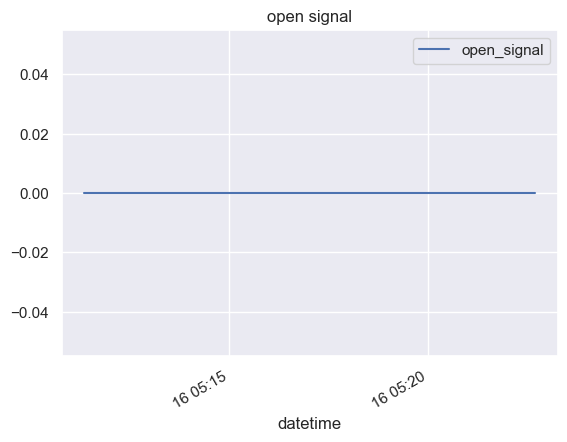

In [45]:
y.tail()
y.plot(y= "open_signal", title="open signal")
plt.show()